<a href="https://colab.research.google.com/github/philip-papasavvas/ml_sandbox/blob/main/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Processing (NLP) Project using the SMS Spam dataset**

The following project will look at applying machine learning techniques, specifically for a natural language processing problem. The problem will focus on using SMS message data, taken from the Kaggle website, where the data was originally curated from the UCI Machine Learning repository. The dataset contains almost 5,600 text messages in English, and are labelled with either ham (not spam), or spam.

In this project we will explore concept such as: 
* **Feature engineering**: assessing the messages to add features to each one, such as the presence of exclamation marks, capital letters, the length of each message, and so on.
* **Lemmaisation**: this involves converting each word into its base form, for example by removing its ending. Converting the word running to run is an example of lemmaisation.
* **Bag of words**: This approach uses a collection of words to represent a sentence, taking account of the number of occurences of each word.

The data used in this project can be found here:
* https://www.kaggle.com/uciml/sms-spam-collection-dataset
* https://archive.ics.uci.edu/ml/datasets/sms+spam+collection

This workbook will have the following outline:
1. **Exploratory Data Analysis**
2. **Data pre-processing & feature engineering**
3. **Application of common ML models**
4. **Logistic regression**
5. **Decision tree**
6. **NLP Methods: tokenisation, vectorization, bag-of-words**
7. **Logistic regression revisited**
8. **Neural networks**

## 1. Exploratory Data Analysis
First, import the modules needed and load the data. Then, explore the statistics of the underlying data, such as the split between spam/non-spam (ham) messages and the length of the messages.

In [1]:
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # set seaborn as default style even if we use matplotlib

# text preprocessing
import nltk

%matplotlib inline

In [2]:
# import the SMS text file
sms_messages = pd.read_csv(
    'https://raw.githubusercontent.com/philip-papasavvas/ml_sandbox/main/data/SMSSpamCollection.txt',
    sep='\t', names=['label', 'message'])

In [3]:
print(f"{len(sms_messages[sms_messages['label'] == 'ham'])} non-spam messages \n"
      f"{len(sms_messages[sms_messages['label'] != 'ham'])} spam messages")

4825 non-spam messages 
747 spam messages


We can see that there is an unbalanced dataset. This needs to be considered later on when applying machine learning models such as decision-tree algorithms, which generate a bias on unbalanced datasets. The issue here is when data is dominated by examples of only one type of class, then the classifer that is trained will then be biased towards the majority class, in this case non-spam (ham) messages. So, when the classifier is applied to a test set that is also imbalanced, the classifier yields an optimistic accuracy estimate.

As an example, but also an extreme case, the classifier could assign every test case to the non-spam category, and therefore the accuracy would be equal to the proportion of overall messages that are not non-spam, in this case 87%, which might be judged as a good level of accuracy. 

This is a well known problem in binary classification and machine learning, and can be counterbalanced in a number of ways, see the topic of discussion [here](https://stats.stackexchange.com/questions/28029/training-a-decision-tree-against-unbalanced-data).

In [4]:
sms_messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Let's look at some examples of ham and spam messages

In [5]:
spam_messages = sms_messages.loc[sms_messages['label']=='spam', 'message'] # pd.Series
non_spam_messages = sms_messages.loc[sms_messages['label']=='ham', 'message'] # pd.Series

np.random.seed(1)

print("Spam message examples: \n", "*" * 30, "\n \n")
for random_choice in np.random.randint(0, len(spam_messages), 5):
    print(f"{spam_messages.iloc[random_choice]} \n \n")

    
print("Non-spam message examples: \n", "*"*30, "\n \n")
for random_choice in np.random.randint(0, len(non_spam_messages), 5):
    print(f"{non_spam_messages.iloc[random_choice]} \n \n")

Spam message examples: 
 ****************************** 
 

Congratulations ur awarded 500 of CD vouchers or 125gift guaranteed & Free entry 2 100 wkly draw txt MUSIC to 87066 TnCs www.Ldew.com1win150ppmx3age16 
 

RGENT! This is the 2nd attempt to contact U!U have WON £1250 CALL 09071512433 b4 050703 T&CsBCM4235WC1N3XX. callcost 150ppm mobilesvary. max£7. 50 
 

You are guaranteed the latest Nokia Phone, a 40GB iPod MP3 player or a £500 prize! Txt word: COLLECT to No: 83355! IBHltd LdnW15H 150p/Mtmsgrcvd18+ 
 

XMAS iscoming & ur awarded either £500 CD gift vouchers & free entry 2 r £100 weekly draw txt MUSIC to 87066 TnC www.Ldew.com1win150ppmx3age16subscription  
 

Santa calling! Would your little ones like a call from Santa Xmas Eve? Call 09077818151 to book you time. Calls1.50ppm last 3mins 30s T&C www.santacalling.com 
 

Non-spam message examples: 
 ****************************** 
 

Like I made him throw up when we were smoking in our friend's car one time, it was awesome 
 



From the few examples above, we see that the ham and spam messages differ quite a lot in terms of the attributes of the messages- length, number of words, presence of website, punctuation, use of words, and so on. In the next section, therefore, we will perform pre-processing and feature extraction.

## 2. Data pre-processing & feature engineering
Upon initial inspection of some examples of the messages, we can extract features to enrich the amount of data we are working with to classify whether a message is spam or not.

It's important that we understand the data well, to have the ability to add more features. This will enable us to carry out feature engineering more effectively. This is extremely important in the field of natural language processing (and spam classification), where feature engineering is one of the most important parts of the process.

#### Initial thoughts
Immediately, the following attributes stand out:
- **length of messages**: spam messages look longer
- **number of words**: spam messages seem to have more words
Let's add these features and compare and contrast the spam/ham data.

In [6]:
sms_messages['length'] = sms_messages['message'].apply(len)
sms_messages['word_count'] = [len(x.split()) for x in sms_messages["message"]]

In [7]:
sms_messages.describe()

,length,word_count
count,5572.000000,5572.000000
mean,80.489950,15.597452
std,59.942907,11.404053
min,2.000000,1.000000
25%,36.000000,7.000000
50%,62.000000,12.000000
75%,122.000000,23.000000
max,910.000000,171.000000


It looks like there are some outliers for the **length** and **word_count**, so we will plot the distributions for these with a limit on the maximum value, of 200 for length, and words count of 50.

Text(0.5, 0.98, 'length of message by type')

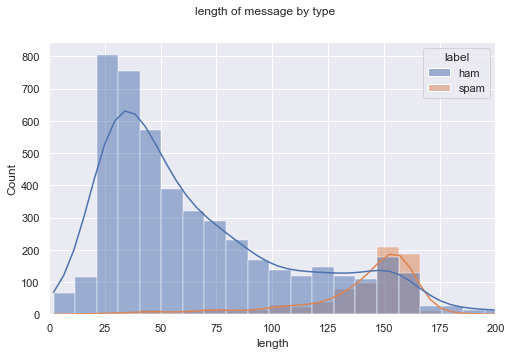

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(data=sms_messages, x='length', hue='label', kde=True)
plt.xlim(0,200)
plt.suptitle('length of message by type')

Clearly, we can see that the spam messages are **longer** than ham messages, and have a greater dispersion.

Text(0.5, 0.98, 'word_count of message by type')

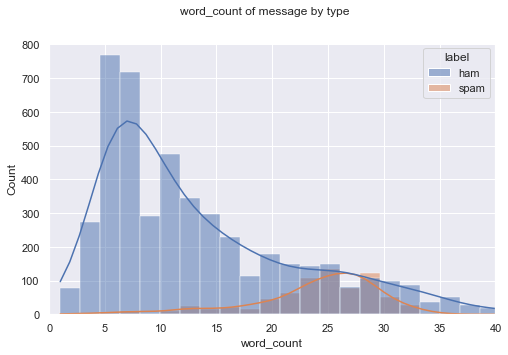

In [9]:
plt.figure(figsize=(8,5))
sns.histplot(data=sms_messages, x='word_count', hue='label', kde=True)
plt.xlim(0,40)
plt.suptitle('word_count of message by type')

Again, spam messages have **more words** than ham messages. On average, ham messages are around 5-10 words, with spam messages being around 25-30 words long. Further, we can see the dispersion for ham messages is much larger than for spam ones.

In [10]:
sms_messages['is_spam'] = np.where(sms_messages['label'] == 'spam', 1, 0)

#### Further feature extraction

Having investigated some examples of spam and non-spam messages above, we see that spam messages have:
- **more** capital letters
- **more** numbers: prompting the user that they have won a specific amount, or prompting them to call/message a specific number
- **more** punctuation: question marks and exclamation marks
- **presence of URL**: spam messages seem to have URL/websites in them
- **presence of phone numbers**: spam messages seem to have phone numbers/text messages to contact to collect prizes. These numbers might be longer than a number used in a ham message, so we will search for sufficiently long ones.


We can assess these intuitions later when running classifiers for the messages.
At the moment, we will not apply any common natural language processing techniques, in terms of reducing the size of the messages to key words, removing punctuation, but will instead use the features we've already extracted to test a couple of supervised learning models.

Below I will write functions and demonstrate their results for each of these features

In [11]:
import re
# get a population of spam messages on which to test the functions 
spam_messages = sms_messages.loc[sms_messages['label'] == 'spam', 'message'] 

print(f"There are {len(spam_messages)} total spam messages")

There are 747 total spam messages


In [12]:
# count the number of capital words
def count_capital_words(input_str: str) -> int:
    return sum(map(str.isupper, input_str.split()))
    
sms_messages['count_capitals'] = sms_messages['message'].apply(count_capital_words)
random_spam_msg = spam_messages.iloc[np.random.randint(0, 100)]

print(f"Original message: \n {random_spam_msg} \n")
print(f"Function count_capital_words: {count_capital_words(random_spam_msg)}")

Original message: 
 FreeMsg Why haven't you replied to my text? I'm Randy, sexy, female and live local. Luv to hear from u. Netcollex Ltd 08700621170150p per msg reply Stop to end 

Function count_capital_words: 0


In [13]:
# function to count the number of numeric characters in a string
def count_numerics(input_str: str) -> int:
    return len(re.sub("[^0-9]", "", input_str))

sms_messages['numeric_count'] = sms_messages['message'].apply(count_numerics)

random_spam_msg = spam_messages.iloc[np.random.randint(0, 100)]
print(f"Original message: \n {random_spam_msg} \n")
print(f"Function count_numerics: {count_numerics(random_spam_msg)}")


Original message: 
 Fancy a shag? I do.Interested? sextextuk.com txt XXUK SUZY to 69876. Txts cost 1.50 per msg. TnCs on website. X 

Function count_numerics: 8


In [14]:
# count number of exclamation/question marks in each message 
def count_exclamation_question(input_str: str) -> int:
    return len(re.sub("[^!?]", "", input_str))

sms_messages['exclamation_question_count'] = sms_messages['message'].apply(count_exclamation_question)

random_spam_msg = spam_messages.iloc[np.random.randint(0, 100)]
print(f"Original message: \n {random_spam_msg} \n")
print(f"Function exclamation_question_count: {count_exclamation_question(random_spam_msg)}")

Original message: 
 URGENT! Your Mobile No. was awarded £2000 Bonus Caller Prize on 5/9/03 This is our final try to contact U! Call from Landline 09064019788 BOX42WR29C, 150PPM 

Function exclamation_question_count: 2


In [15]:
# basic method to look for a couple of the most common attributes of a URL/website
# this can be made more sophisticated
def search_for_website(input_str: str) -> int:
    return 1 if bool(re.search('http://www|www.|.com', random_spam_msg)) == True else 0

sms_messages['is_website'] = sms_messages['message'].apply(search_for_website)

random_spam_msg = spam_messages.iloc[np.random.randint(0, 100)]
print(f"Original message: \n {random_spam_msg} \n")
print(f"Function search_for_website: {search_for_website(random_spam_msg)}")

Original message: 
 You are a winner U have been specially selected 2 receive £1000 or a 4* holiday (flights inc) speak to a live operator 2 claim 0871277810910p/min (18+)  

Function search_for_website: 0


In [16]:
# method to look for phone numbers, defined as numbers with more than 6 numbers, which
# a spam message might ask you to text/call if you've won a prize/to redeem an offer
# this also can be made more sophisticated
def search_for_prize_number(input_str: str) -> int:
    # use regex to search for 5 or more digits
    return 1 if bool(re.search(r'\d{5,}', random_spam_msg)) == True else 0 

sms_messages['is_prize_number'] = sms_messages['message'].apply(search_for_prize_number)

random_spam_msg = spam_messages.iloc[np.random.randint(0, 100)]
print(f"Original message: \n {random_spam_msg} \n")
print(f"Function search_for_prize_number: {search_for_prize_number(random_spam_msg)}")

Original message: 
 For ur chance to win a £250 wkly shopping spree TXT: SHOP to 80878. T's&C's www.txt-2-shop.com custcare 08715705022, 1x150p/wk 

Function search_for_prize_number: 1


#### Enriched feature dataframe inspection
Inspect the new dataframe with the added features

In [17]:
sms_messages.head(5).T

,0,1,2,3,4
label,ham,ham,spam,ham,ham
message,"Go until jurong point, crazy.. Available only ...",Ok lar... Joking wif u oni...,Free entry in 2 a wkly comp to win FA Cup fina...,U dun say so early hor... U c already then say...,"Nah I don't think he goes to usf, he lives aro..."
length,111,29,155,49,61
word_count,20,6,28,11,13
is_spam,0,0,1,0,0
count_capitals,0,0,2,2,1
numeric_count,0,0,25,0,0
exclamation_question_count,0,0,0,0,0
is_website,0,0,0,0,0
is_prize_number,1,1,1,1,1


Now that we've added many features to the data, let's look at the frequency distributions for those with continuous variables, except length and word count (covered earlier). 
We will group by the 'label' (classifying ham or spam), therefore looking at:
- numeric_count
- exclamation_question_cpunt
- count_capitals

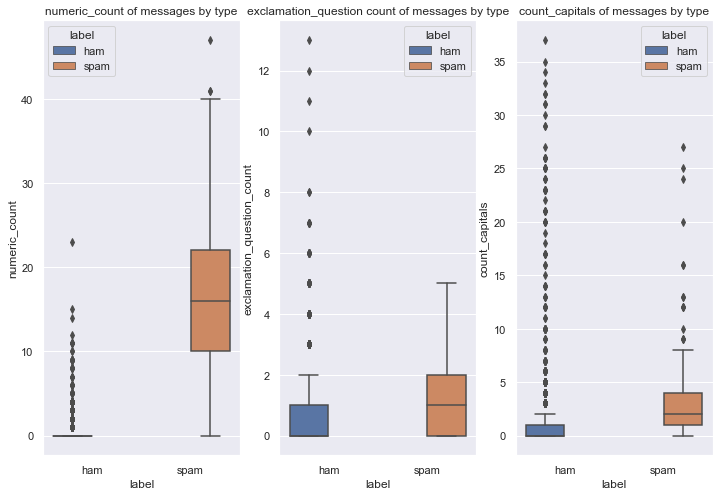

In [18]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(131)
ax1.set_title("numeric_count of messages by type")
g = sns.boxplot(data=sms_messages, x='label', y='numeric_count', hue='label', ax=ax1)

ax2 = fig.add_subplot(132)
ax2.set_title("exclamation_question count of messages by type")
g = sns.boxplot(data=sms_messages, x='label', y='exclamation_question_count', hue='label', ax=ax2)

ax3 = fig.add_subplot(133)
ax3.set_title("count_capitals of messages by type")
g = sns.boxplot(data=sms_messages, x='label', y='count_capitals', hue='label', ax=ax3)

plt.close(2)
plt.close(3)

it looks like in general, spam messgaes have:
- more numbers 
- more exclamation/question marks
- more capital letters
than ham messages.

## 3. Application of common ML models
After adding features to the data, with regard to the number of numeric characters in each message, the length of the message, and the count of any exclamation and punctuation marks, we can attempt to feed in this data into a machine learning model to classify messages if they are spam or not. It might be unusual to do this in an NLP problem, but let's try it anyway and investigate the results we get, before diving into more detailed NLP techniques.


#### Adjustments to the data
As mentioned above we have an unbalanced dataset, where 13% of the messages in the dataset are spam, and the rest are not. In order to counterbalance this, we will use the two solutions:
 - **undersample** the majority spam class, or **oversample** the minority non-spam class, to prevent the bias in the first place
 - modify the **cost of misclassification** to prevent bias.
 
I'd like to highlight the dangers of not balancing the dataset to address the imbalance between the spam/non-spam messages. Therefore I will use a logistic regression classifier whilst using a stratified sample (I will adjust the sampling of the data to ensure the split datasets have the same proportion of spam/non-spam messages). 

Before training the machine learning model it is crucial that we separate out the dataset into three different parts:
- **training set**: this input data is used for the model to learn about the dataset, and fit its parameters
- **validation set**: this data is used to evlatue a given model in order to tune the model parameters
- **testing set**: test set is used once a model is completely trained, and will give you the accuracy of the model

#### Discussion on the splitting of data into: training/validation/test sets
- The purpose of the **training set** is to train the model to learn about the dataset, and fit its parameters. Therefore, this data is used to choose the optimal parameters for the model, hence its aim is to minimise the cost based on the predictions. Since these parameters are chosen to optimise the performance on the training set, the apparent performance of the parameters, evaluated on the training set, will be overly optimistic.

- The **validation set** is used to select the best model. When evaluating any model using the validation set, you get a representative estimate of the cost function, since the choice is made towards the model that peforms best on the validation set biased towards the estimate the model provides. So the apparent peformance of the model will *see* the data, but won't learn from it. Therefore, strictly speaking, the dataset does influence the model, but only indirectly.

- The need for the **test set** is that it gives an unbiased estimate for how good your final choice of model is. Since you've **trained** the model using the **training set**, and evaluated the model using the **validation** set, the gold standard is to test the model you've chosen on unseen data, the **test set**. It gives an unbiased estimate of the actual performance you will get from the model, since the model hasn't been fitted/tuned to any of this **unseen** data. You cannot use the **training set** since the model parameters are biased towards this data, and likewise for **validation set**, highlighting the need for this third set of data, the **test set**.

### Model performance measures
We will use three performance measures to assess the models we will be training and fitting for the data.

#### Precision
This is the ratio of correctly predicted positive observations compared to the total predicted positive observations. High precision means that there is a low false positive rate, that is, not very many observations are predicted as positive falsely.

*Another way of wording: Of all predicted positive observations, what was the fraction that were positive?*

*Or: Positive predictive value*

#### Recall (sensitivity)
This is the ratio of the correctly predicted positive observations compared to all positive observations.

*Another way of wording: Of all of the actual positive observations, what fraction did we predict as positive?*

*Or: True positive rate*

#### F1-score
This is the weighted average of the precision and recall. It takes into account both false positives and false negatives. This is a useful measure to combine both the precision and recall into one measure.

#### Data inspection


In [19]:
sms_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   label                       5572 non-null   object
 1   message                     5572 non-null   object
 2   length                      5572 non-null   int64 
 3   word_count                  5572 non-null   int64 
 4   is_spam                     5572 non-null   int64 
 5   count_capitals              5572 non-null   int64 
 6   numeric_count               5572 non-null   int64 
 7   exclamation_question_count  5572 non-null   int64 
 8   is_website                  5572 non-null   int64 
 9   is_prize_number             5572 non-null   int64 
dtypes: int64(8), object(2)
memory usage: 435.4+ KB


Split the data using the **scikit-learn** train_test_split function.

In [20]:
from sklearn.model_selection import train_test_split
feature_names = ['length', 'word_count', 'numeric_count', 'exclamation_question_count',
                 'count_capitals', 'is_website']
X = sms_messages[feature_names]
y = sms_messages['is_spam']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, # 20% of the data will be used to test the model accuracy
    random_state=1,
    stratify=y) # stratify the data to keep the proportion of ham/spam messages consistent

# further split the train set into 
# choose the validation set to be 25% of the training set we've just taken, overall we
# have 20% of the original data as the validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, 
    test_size=0.25,
    random_state=1,
    stratify = y_train)

## 4 Logistic regression
Firstly we will apply logistic regression to the data, using the training set to train the model, and then the test set to evaluate the performance of the model.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score

logistic = LogisticRegression(solver='lbfgs')
logistic.fit(X_train, y_train)

x_test_logistic_pred = logistic.predict(X_test)
x_test_logistic_accuracy = accuracy_score(y_true=y_test, y_pred=x_test_logistic_pred)
print(f"Accuracy score for the test set was {100*x_test_logistic_accuracy:.2f}% \n ")

Accuracy score for the test set was 96.59% 
 


In [22]:
confusion_test_logistic = confusion_matrix(y_true=y_test, y_pred=x_test_logistic_pred)

It would be useful to write a function to plot a confusion matrix for the results of the two tests.

In [23]:
def plot_confusion_matrix(input_matrix: np.ndarray, labels=None, title: str = None):
    """Seaborn plot of the confusion matrix, given labels (if so)"""
    
    labels = labels if labels else ['Negative (0)', 'Positive (1)']
        
    fig, ax = plt.subplots()
    fig = plt.figure(figsize=(8,8))
    sns.heatmap(data=input_matrix, xticklabels=labels, yticklabels=labels, ax=ax,
               cmap='YlGnBu', annot=True, fmt='g',
               annot_kws={'size': 16})
    ax.set_xlabel("Prediction")
    ax.set_ylabel("Actual")
    ax.set_title("Confusion Matrix")
    plt.close()
        
    return fig      

#### Test set results
Inspect the results from the confusion matrix for the test set.

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.91      0.83      0.87       149

    accuracy                           0.97      1115
   macro avg       0.94      0.91      0.92      1115
weighted avg       0.97      0.97      0.97      1115



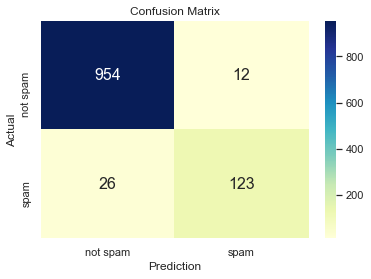

In [24]:
from sklearn.metrics import classification_report

plot_confusion_matrix(confusion_test_logistic, labels=['not spam', 'spam'])
print(classification_report(y_test, x_test_logistic_pred))

Therefore, we see that using the **test set**:
- Of 966 non-spam messages, 954 were classified as not spam, with 12 incorrectly classified as spam. Therefore, the **recall was 99% for not spam**.
- From a total of 149 spam messages, 123 were predicted correctly. The **recall for not spam was 83%**. 

Overall, the accuracy for the test set is good, at 97%. However, since we only have 149 observations that are spam, compared to 966 observations that are 
non-spam, and therefore the peformance metrics in terms of precision, recall and f1-score are lower for the spam classifier.

## 5 Decision Tree
In this example, we will use a classification (decision) tree, a supervised learning algorithm that can be used for classification, in this case to ascertain whether the message is spam or ham. The decision tree algorithm creates a model that can be used to predict the outcome of a the target variable (in this case ham or spam) by learning simple decision rules learned from the training data. As I will cover below, in a decision tree algorthim, the feature values are preferred to be categorical/discrete, rather than continuous, but we will fit the decision tree to compare the model performance with that of other supervised learning methods.

In this decision tree for predicting if a text is ham or spam, we start at the **root** of the tree, comparing the results of the root with the the attribute of the message we're looking at. In this context, the first decision node at the root will split one of the features of the dataset. This could be the message length, for instance. Depending on the value of the length of the message, the route will take one of the two branches, before reaching the next decision node, and so on, until at the end the algorithm reaches the end leaf, where a decision is made whether the message is **ham** or **spam**.

As mentioned previously, we will ensure that the binary decision tree has an automatic adjustment according to the proportion of spam/non-spam messages, else the tree might become biased toward the more dominant spam message classification.

To adjust for this, we will pass **class_weight='balanced'** parameter into the decision tree, to peform an adjustment according to the proportion of frequencies of each class. This decision tree algorithm will therefore become a **class-weighted decision tree**.

#### Fit the model
We will now fit the model for the decision tree, and show the text detailing the set of rules generated by the decision tree.

In [25]:
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn import tree

import graphviz

decision_tree_model = DecisionTreeClassifier(class_weight='balanced')
decision_tree_model.fit(X_train, y_train)

tree_rules = export_text(decision_tree_model, 
                        show_weights=True,
                        feature_names=feature_names)

decision_test_pred = decision_tree_model.predict(X_test)
decision_test_accuracy = accuracy_score(y_true=y_test, y_pred=decision_test_pred)
print(f"Accuracy score for the test set was {100*decision_test_accuracy:.2f}% \n ")

Accuracy score for the test set was 96.59% 
 


#### Test set results
Let's inspect the confusion matrix for the test set.

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       966
           1       0.88      0.86      0.87       149

    accuracy                           0.97      1115
   macro avg       0.93      0.92      0.93      1115
weighted avg       0.97      0.97      0.97      1115



<Figure size 576x576 with 0 Axes>

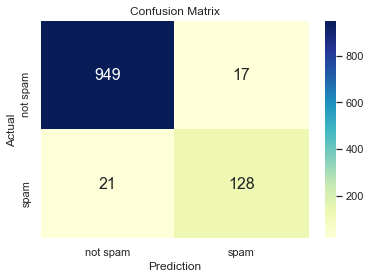

In [26]:
print(classification_report(y_test, decision_test_pred))
plot_confusion_matrix(confusion_matrix(y_true=y_test, y_pred=decision_test_pred),
                      labels=['not spam', 'spam'])

Therefore, we see that using the **test set**:
- Of 966 non-spam messages, 948 were classified as not spam, with 18 incorrectly classified as spam. Therefore, the **recall was 98% for not spam**.
- From a total of 149 spam messages, 128 were predicted correctly. The **recall for not spam was 86%**. 

Overall, the accuracy for the test set is good, at 97%. However, since we only have 149 observations that are spam, compared to 966 observations that are 
non-spam, and therefore the peformance metrics in terms of precision, recall and f1-score are lower for the spam classifier.

#### Discussion
As mentioned above, the Decision Tree algorithm is usually used for problems where the feature vectors are categorical or discrete, whereas in this case they are continuous. It would be easy to change some of the features **numeric_count** and **exclamation_question_count** to instead be boolean flags indicating if a message contains numbers in it, or exclamation/question marks, therefore making the continuous data more discrete.
However, for the purposes of this project, the consideration that the number of numeric characters and the number of exclamation/question marks was considered important to distinguishing whether a text is spam/ham.

The performance of the decision tree can be increased by **pruning**, a practice which involves removing the branches that have the least importance to the final outcome of the text classification as spam/ham.

## 6. NLP Methods: tokenisation, vectorization, bag-of-words
So far we have looked at two supervised learning algorithms: **logistic regression** and **decision tree algorithm**. However, given that the messages contain a large population of words, instead of using feature engineering to extract features about the attributes of the messages, as above, we can insead convert the messages into **cleaned messages**. The aim of this exercise is to reduce each message into a list of token, which are meaningful words that can be extracted from each text, this is known as **tokenisation**.

#### Tokenisation
This involves converting the original text strings in each message into a list of tokens (meaningful words) by removing the stopwords, and punctuation.

It doesn't seem like punctuation in messages (commas, full stops) gives us lots of insight about whether a message is spam or not, so we will remove these bits of punctuation from the messages. 
In addition to this, common words (the, a, there, etc.) appearing in the English language (stopwords) do not give much away regarding if the messages are spam or not.
Therefore, we will go ahead and remove stopwords - making use of the **corpus** within the **nltk** package to do so.

We will use a function to:
* remove punctuation
* remove stopwords - making use of the **corpus** within the **nltk** package.

In [27]:
from nltk.corpus import stopwords
english_stopwords = stopwords.words('English')
len(english_stopwords)


179

We can see that overall there are 179 stopwords! These can be removed from the dataset to reduce each message and will ensure smaller feature vectors for use in our machine learning model. Now let's construct a function to remove punctuation from a text, as well as removing the stopwords, and test the function afterwards.

In [28]:
def clean_text(input_str: str) -> list:
  """Method to clean input text (list)"""
  # remove punctuation from the list
  no_punc = [char for char in input_str if char not in string.punctuation]
  
  # join the chaaracters with no punctuation to get the original words
  no_punc = "".join(no_punc)

  # remove stopwords and split the long string containing words into a list
  return [word for word in no_punc.split() if word not in english_stopwords]

random_msg = sms_messages['message'].iloc[np.random.randint(len(sms_messages))]
print(f"Original message: \n {random_msg} \n \n") 
print(f"Cleaned message removing the stopwords, and punctuation, and converting the "
      f"string into a list of tokens gives: \n {clean_text(random_msg)}")

Original message: 
 Wen ur lovable bcums angry wid u, dnt take it seriously.. Coz being angry is d most childish n true way of showing deep affection, care n luv!.. kettoda manda... Have nice day da. 
 

Cleaned message removing the stopwords, and punctuation, and converting the string into a list of tokens gives: 
 ['Wen', 'ur', 'lovable', 'bcums', 'angry', 'wid', 'u', 'dnt', 'take', 'seriously', 'Coz', 'angry', 'childish', 'n', 'true', 'way', 'showing', 'deep', 'affection', 'care', 'n', 'luv', 'kettoda', 'manda', 'Have', 'nice', 'day', 'da']


We saw earlier the original text has been reduced in size from a string, to a list of strings (words).

We will go ahead and apply this **clean_text** function to all of our messages.

In [29]:
sms_messages['cleaned_message'] = sms_messages['message'].apply(clean_text)

### Vectorization
We can continue normalising this text using the **nltk** package. We will use **vectorisation** to use the converted message (now a list of 'token' words) as a vector that can be understood by other machine learning models we wish to apply.

For this we will use the bag-of-words model. Using this model, each original message will be represented as a bag of its words, noting the freqeuncy of each word. Note that the ordering of the words will be disregarded. The frequency of each word will then be used in the feature vector for training a classifier later on.

We will use the **CountVectorizer** from **scikit-learn** to get a matrix of token counts, a two-dimensional matrix, where one dimension contains all of the words (one row per word), and the other dimension is each individual message, in this case one column per message. This matrix will look as follows:

<table border = “1“>
<tr>
<th></th> <th>Message 1</th> <th>Message 2</th> <th>...</th> <th>Message N</th> 
</tr>
<tr>
<td><b>Word 1 Count</b></td><td>0</td><td>1</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word 2 Count</b></td><td>0</td><td>0</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>...</b></td> <td>1</td><td>2</td><td>...</td><td>0</td>
</tr>
<tr>
<td><b>Word N Count</b></td> <td>0</td><td>1</td><td>...</td><td>1</td>
</tr>
</table>

Since we have the population of all messages, we expect lots of different words to have been used, and therefore the matrix of tokens we would expect to be sparse.

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
# we will use the raw messages, and the clean_text function we defined above
bag_of_words_transform = CountVectorizer(analyzer=clean_text).fit(sms_messages['message'])

print(f'In total we have: {len(bag_of_words_transform.vocabulary_)} words in the matrix')

In total we have: 11617 words in the matrix


Inspect how the transformer works using an example message...

In [31]:
orig_message = sms_messages['message'].iloc[100]

print(f"Original message: {orig_message} \n \n"
      f"Vector representation of message: \n {bag_of_words_transform.transform([orig_message])}")

Original message: Please don't text me anymore. I have nothing else to say. 
 
Vector representation of message: 
   (0, 2362)	1
  (0, 3356)	1
  (0, 4893)	1
  (0, 6315)	1
  (0, 6474)	1
  (0, 8672)	1
  (0, 9746)	1
  (0, 10570)	1


Hence, we see all of the words in the (cleaned) text are unique, and there are 8 different words. If there are over 11,000 words in the overall vocabulary, we would expect a **sparse matrix** for the population of all messages.

In [32]:
bow_message_mtrx = bag_of_words_transform.transform(sms_messages['message'])

print(f"Shape of matrix of tokens: {bow_message_mtrx.shape}")
print(f"Non-zero occurences in matrix: {bow_message_mtrx.nnz}")

print(f"Therefore, the matrix is "
      f"{100*(bow_message_mtrx.nnz/(bow_message_mtrx.shape[0]*bow_message_mtrx.shape[1])):.2f} % full with non-zero values")

Shape of matrix of tokens: (5572, 11617)
Non-zero occurences in matrix: 56024
Therefore, the matrix is 0.09 % full with non-zero values


## 7. Logistic Regression revisited
Now that we have a different representation for the features of the messages, let's try the logistic regression model again for the messages, and see if the performance is different. We will still be taking the same sample of the messages, since we have set the **random_state** parameter in **train_test_split** to be 1.

In [33]:
messages_train, messages_test, new_y_train, new_y_test = train_test_split(
    sms_messages['message'], y, 
    test_size=0.2, # 20% of the data will be used to test the model accuracy
    random_state=1,
    stratify=y) # stratify the data to keep the proportion of ham/spam messages consistent

Again we will repeat the bag of words model to vectorize the sentences using the Count Vectorizer. Once we have done this, we create the feature vectors for each message of the training and test set.

In [34]:
# we will use the raw messages, and the clean_text function we defined above
vectorizer = CountVectorizer(analyzer=clean_text).fit(messages_train)
new_x_train = vectorizer.transform(messages_train)
new_x_test = vectorizer.transform(messages_test)

In [35]:
new_x_train

<4457x10088 sparse matrix of type '<class 'numpy.int64'>'
	with 44590 stored elements in Compressed Sparse Row format>

We have around 4,500 messages in the training set, with each message having over 10,000 dimensions, the size of the vocabulary.

Now let's fit the new logistic regression model for the tokenized messages.

In [36]:
new_logistic_classifier = LogisticRegression()
new_logistic_classifier.fit(new_x_train, new_y_train)

LogisticRegression()

#### Test set results
Let's inspect the results of the test set

In [37]:
new_x_test_logistic_pred = new_logistic_classifier.predict(new_x_test)
new_x_test_logistic_accuracy = accuracy_score(y_true=new_y_test, 
                                              y_pred=new_x_test_logistic_pred)
print(f"Accuracy score for the test set was {100*new_x_test_logistic_accuracy:.2f}% \n ")

confusion_test_new_logistic = confusion_matrix(y_true=new_y_test, 
                                               y_pred=new_x_test_logistic_pred)

Accuracy score for the test set was 97.49% 
 


              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



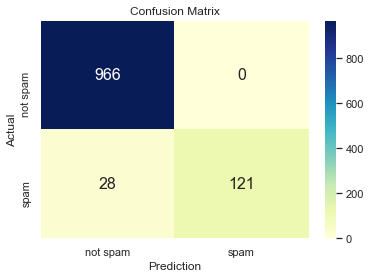

In [38]:
plot_confusion_matrix(confusion_test_new_logistic, labels=['not spam', 'spam'])
print(classification_report(new_y_test, new_x_test_logistic_pred))

Therefore, we see that using the **test set**:
- Of 966 non-spam messages, **all** were classified as not spam, a 100% recall rate.
- From a total of 149 spam messages, 121 were predicted correctly. The **recall for not spam was 81%**. 

Overall, the accuracy for the test set is good, at 97%. However, since we only have 149 observations that are spam, compared to 966 observations that are 
non-spam, and therefore the peformance metrics in terms of precision, recall and f1-score are lower for the spam classifier.

#### Comparison of the two different logistic regression models

The results of the previous logistic regression just using the features of the messages as message length, presence of website, number of words in each message, presence of phone numbers (and so on.) yielded the following results:

In [39]:
print("*"*90)
print("Original logistic regression without vectorising and cleaning the messages: \n")
print(classification_report(y_test, x_test_logistic_pred))
print("*"*90)

print("New logistic regression (after vectorisation and cleaning) the messages: \n")
print(classification_report(y_test, new_x_test_logistic_pred))

******************************************************************************************
Original logistic regression without vectorising and cleaning the messages: 

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       966
           1       0.91      0.83      0.87       149

    accuracy                           0.97      1115
   macro avg       0.94      0.91      0.92      1115
weighted avg       0.97      0.97      0.97      1115

******************************************************************************************
New logistic regression (after vectorisation and cleaning) the messages: 

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       966
           1       1.00      0.81      0.90       149

    accuracy                           0.97      1115
   macro avg       0.99      0.91      0.94      1115
weighted avg       0.98      0.97      0.97      1115



Therefore, we see that the accruacy of the two approaches is the same, with 97% performance in each instance.

In the first (original) logistic regression (fewer features), the precision and recall are both very high, as well as the f1-score, which shows similarly high scores. This '0' category is for the non-spam messages.

However, there is some variation in the classification of spam messages ('1' category). The **precision** for the second (vectorized messages) linear regression is 100%, meaning all of the messages that were predicted as spam, were indeed spam. Whilst the first logistic regression found that of all messages predicted as spam, 91% of them were spam.
Secondly, the recall is quite similar for both; the second logistic regression found that of all the spam messages, 81% were correctly predicted as spam, whilst in the first logistic regression, 83% of all spam messages were correctly predicted.


# 8. Neural Network

### Introduction
First, let's cover a short introduction to neural networks... (from [realpython.com](https://realpython.com/python-keras-text-classification/)):

> Neural networks, or sometimes called artificial neural network (ANN) or feedforward neural network, are computational networks which were vaguely inspired by the neural networks in the human brain. They consist of neurons (also called nodes) which are connected like in the graph below.

> You start by having a layer of input neurons where you feed in your feature vectors and the values are then feeded forward to a hidden layer. At each connection, you are feeding the value forward, while the value is multiplied by a weight and a bias is added to the value. This happens at every connection and at the end you reach an output layer with one or more output nodes.

> If you want to have a binary classification you can use one node, but if you have multiple categories you should use multiple nodes for each category:
![img](https://files.realpython.com/media/ANN.a2284c5d07a3.png)

The most complex part of the neural network is the calculation of the weights, as the feature vectors and values at each connection are subject to these weights, which ultimately determine the outcome of the network.

In a neural network the algorithm starts by initialising th ewiehgts with random values and they are then trained using backpropagation (backprop). Backprop is done using optimisation methods such as gradient descent to reduce the error between the computed output (in this case whether the message is labelled ham or spam), and the desired output. The error is determined by a loss function, which we'd like to minimise.

### Keras
We will use Keras for applying neural networks to our problem here, which is a library that can be used on top of popular Machine Learning library such as Tensorflow by Google.

We will go ahead and construct a neural network for this problem.

In [40]:
# pip install keras # run this if you've not installed keras

In [55]:
from keras.models import Sequential
from keras import layers

input_dim = new_x_train.shape[1] 
print(f"There are {input_dim} features going into the neural network model")

There are 10088 features going into the neural network model


In [56]:
nn_model_one = Sequential()
nn_model_one.add(layers.Dense(10, input_dim=input_dim, activation='relu'))
nn_model_one.add(layers.Dense(1, activation='sigmoid'))

As shown above, for the input_dim parameter, we have specified th enumber of parameters, in this case there are over 10 000 rows of data going into the model. We specify that the first hidden layer has 10 nodes, and uses the **relu** activation function.
The output layer then has one node and uses the **sigmoid** activation function.

Before the model is trained, we need to configure the learning process using the compile method. Since we are trying to estimate if a message is ham or spam, we will use the **'binary_crossentropy'** for the loss function and the **'Adam'** optimiser (a stochastic gradient descent algorithm).
We can then see what the model looks like

In [57]:
nn_model_one.compile(loss='binary_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])
nn_model_one.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                100890    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 100,901
Trainable params: 100,901
Non-trainable params: 0
_________________________________________________________________


The intuitions of the above, are that there are 10,088 dimensions for each feature vector, and we've specified 10 nodes in the model. So, we need weights for each feature dimension, and each node accounts for 10,088 x 10 = 100 880 parameters, and we have another 10 times an added bias for each node.
In the final node, there are 10 weights, and one bias, giving 11 parameters.

#### Parameters for the neural network: epochs and batch size

Training in neural networks is iterative, so we specify the number of iterations for the model, called **epochs**.
We will run the model for 10 epochs to start, and then can evaluate how the training loss and accuracy changes after each epoch.

**Batch size** is responsible for the number of samples to use in one epoch, that is how many sample are used in one forward/backward pass. It increases the speed of the computation as it needs fewer epochs to run, but also uses more memory. The training set is relatively small,w e we can use a low batch size.

In [58]:
hist = nn_model_one.fit(new_x_train, new_y_train.values,
                       epochs=10,
                       verbose=True,
                       validation_data=(new_x_test, new_y_test.values),
                       batch_size=10)

Epoch 1/10
446/446 [==============================] - 1s 1ms/step - loss: 0.5015 - accuracy: 0.8933 - val_loss: 0.1289 - val_accuracy: 0.9776
Epoch 2/10
446/446 [==============================] - 0s 883us/step - loss: 0.0817 - accuracy: 0.9909 - val_loss: 0.0623 - val_accuracy: 0.9857
Epoch 3/10
446/446 [==============================] - 0s 868us/step - loss: 0.0353 - accuracy: 0.9951 - val_loss: 0.0495 - val_accuracy: 0.9857
Epoch 4/10
446/446 [==============================] - 0s 869us/step - loss: 0.0207 - accuracy: 0.9957 - val_loss: 0.0460 - val_accuracy: 0.9857
Epoch 5/10
446/446 [==============================] - 0s 894us/step - loss: 0.0125 - accuracy: 0.9969 - val_loss: 0.0444 - val_accuracy: 0.9865
Epoch 6/10
446/446 [==============================] - 0s 867us/step - loss: 0.0080 - accuracy: 0.9982 - val_loss: 0.0447 - val_accuracy: 0.9865
Epoch 7/10
446/446 [==============================] - 0s 890us/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0461 - val_accuracy: 0

In [59]:
# don't forget to run this if you want to train the model again!
# from keras.backend import clear_session
# clear_session()

In [66]:
loss, accuracy = nn_model_one.evaluate(new_x_train, new_y_train.values, verbose=True)
print(f"Training accuracy of: {100*accuracy:.2f} %")

140/140 [==============================] - 0s 620us/step - loss: 0.0016 - accuracy: 0.9993
Training accuracy of: 99.93 %


The training accuracy is almost 100%! It looks like the model has overfitted the input data.

In [68]:
loss, accuracy = nn_model_one.evaluate(new_x_test, new_y_test.values, verbose=True)
print(f"Testing accuracy of: {100*accuracy:.2f} %")

35/35 [==============================] - 0s 809us/step - loss: 0.0498 - accuracy: 0.9848
Testing accuracy of: 98.48 %


The accuracy of the testing set at 98.5% is definitely the best model to use, beating the two linear regression models previously used, and the decision tree model.

We use the helper method defined on [realpython.com](https://realpython.com/python-keras-text-classification/) to plot the accruacy and loss of the model.


In [76]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

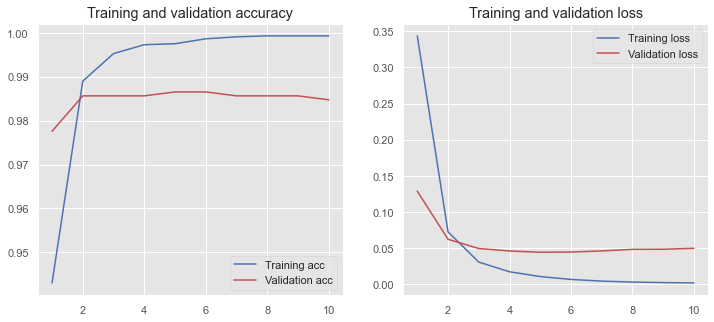

In [77]:
plot_history(history=hist)

We can see from the above that the training accuracy reached almost 100% after just 6 epochs. We can see that the model was overfitting after around 6 epochs as the validation loss starts rising again. This is usually a good indicator to stop the model.